# Imports and installs

In [1]:
from word_mover_distance import model
import torchtext.vocab as vocab
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import re
import matplotlib.pyplot as plt
from nltk import download
from nltk.corpus import stopwords
import torch
import bert_score
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

/Users/philippmetzger/anaconda3/envs/tm_pip_3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#!pip install jieba
#!pip install word-mover-distance

In [3]:
import pandas as pd
from tqdm.notebook import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import jieba
from sklearn.model_selection import train_test_split

# Load and explore data

In [4]:
path_corpus = "/Users/philippmetzger/OneDrive/PHILIPP/NOVA IMS/2nd Semester/06 Text Mining 4 ECTS/00 Project/corpus/"
cs_en = pd.read_csv(path_corpus + "cs-en/scores.csv")
de_en = pd.read_csv(path_corpus + "de-en/scores.csv")
en_fi = pd.read_csv(path_corpus + "en-fi/scores.csv")
en_zh = pd.read_csv(path_corpus + "en-zh/scores.csv")
ru_en = pd.read_csv(path_corpus + "ru-en/scores.csv")
zh_en = pd.read_csv(path_corpus + "zh-en/scores.csv")

In [5]:
cs_en.head(1)

,source,reference,translation,z-score,avg-score,annotators
0,Uchopíte pak zbraň mezi své předloktí a rameno...,You will then grab the weapon between your for...,You then grasp the gun between your forearm an...,-0.675383,60.0,3


In [6]:
data_list = [cs_en, de_en, en_fi, en_zh, ru_en, zh_en]
names_list = ['cs_en', 'de_en', 'en_fi', 'en_zh', 'ru_en', 'zh_en']
text_columns_list = ['source', 'reference', 'translation']

In [7]:
descriptions = ["Russian into English", "German into English", "Czech into English", "Chinese into English", "English into Chinese", "English into Finish"]

rows = []
zscores = []
avgscores = []
annots = []

i = 0

for element in [ru_en, de_en, cs_en, zh_en, en_zh, en_fi]:
    rows.append(element.shape[0])
    zscores.append(np.round(element["z-score"].mean(),2))
    avgscores.append(np.round(element["avg-score"].mean(), 2))
    annots.append(np.round(element["annotators"].mean(),2))
    i += 1                   
    
exploration_df = pd.DataFrame([rows, zscores, avgscores, annots]).T.rename(columns={0:"rows", 1:"avg z-score", 2:"avg avg-score", 3:"avg annotators"})
exploration_df["description"] = descriptions
exploration_df = exploration_df.set_index("description")
exploration_df

,rows,avg z-score,avg avg-score,avg annotators
description,,,,
Russian into English,17980.0,0.01,74.50,1.30
German into English,21704.0,0.00,71.85,1.50
Czech into English,11585.0,-0.03,69.24,1.89
Chinese into English,26419.0,-0.05,66.06,1.42
English into Chinese,10221.0,-0.06,65.98,1.58
English into Finish,6748.0,-0.14,45.12,1.23


# Naive implementation inspired by Word Mover's distance

In [8]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

In [9]:
glove = vocab.GloVe(name='6B', dim=50)
print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words


## Test it on "de_en"

In [10]:
distances = []

for i in tqdm(range(de_en.shape[0])):
    
    over = False

    a = de_en.iloc[i,1]
    b = de_en.iloc[i,2]

    a = a.lower()
    a = re.sub("[^a-z]", ' ', a)
    a = a.split()

    b = b.lower()
    b = re.sub("[^a-z]", ' ', b)
    b = b.split()

    # Uncommenting the following two lines worsens the correlation
    #a = [word for word in a if word not in stop]
    #b = [word for word in b if word not in stop]

    len_pre_oov1 = len(a)
    len_pre_oov2 = len(b)
    a = [token for token in a if token in glove.itos]
    b = [token for token in b if token in glove.itos]
    diff1 = len_pre_oov1 - len(a)
    diff2 = len_pre_oov2 - len(b)

    if len(a) == 0 or len(b) == 0:
        #print('At least one of the documents had no words that were in the vocabulary. Aborting (returning inf).')
        dist = -1
        over = True

    if not over:
        dist = 0
        for word_a in a:
            distances_this = []
            for word_b in b:

                distances_this.append(torch.dist(get_word(word_a), get_word(word_b)))

            min_dist = min(distances_this)

            dist += min_dist
    
    distances.append(dist)

max_dist = max(distances)
distances = [max_dist if dist == -1 else dist for dist in distances]

  0%|          | 0/21704 [00:00<?, ?it/s]

In [11]:
pearsonr(de_en['avg-score'], distances)[0]

-0.1648361559689596

-0.1648361559689596

In [12]:
kendalltau(de_en['avg-score'], distances)[0]

-0.1396207216132029

-0.1396207216132029

# Word mover's distance
https://pypi.org/project/word-mover-distance/#description

## Convert the embedding model into a dictionary and pass it to word_mover_distance

In [13]:
glove_dict = {}

for i in range(len(glove.vectors)):
    glove_dict[glove.itos[i]] = glove.vectors[i].numpy()

In [14]:
# Get one example
glove_dict['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [15]:
my_model = model.WordEmbedding(model=glove_dict)

## Test word_mover_distance

In [16]:
s1 = 'Obama speaks to the media in Chicago'.lower().split()
s2 = 'The president spoke to the press in Chicago'.lower().split()
wmdistance = my_model.wmdistance(s1, s2)
wmdistance

1.8119693993679309

1.8119693993679309

## Use word_mover_distance on our data

### Version 1: With stopword removal

In [17]:
stop = stopwords.words('english')

In [18]:
data = de_en

wmdistances = []

for row in tqdm(range(data.shape[0])):
    
    s1 = data.iloc[row,1]
    s2 = data.iloc[row,2]
    
    s1 = s1.lower()
    s1 = re.sub("[^a-z]", ' ', s1)
    s1 = s1.split()
    
    s2 = s2.lower()
    s2 = re.sub("[^a-z]", ' ', s2)
    s2 = s2.split()
    
    s1 = [word for word in s1 if word not in stop]
    s2 = [word for word in s2 if word not in stop]
    
    wmdistance = my_model.wmdistance(s1, s2)
    wmdistances.append(wmdistance)

  0%|          | 0/21704 [00:00<?, ?it/s]

#### Replace inf values by maximum

In [19]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
max_dist = max(wmdistances2)
wmdistances2 = [max_dist if dist == -1 else dist for dist in wmdistances2]

In [20]:
pearsonr(de_en['avg-score'], wmdistances2)[0]

-0.27926436711081465

-0.27926436711081465

In [21]:
kendalltau(de_en['avg-score'], wmdistances2)[0]

-0.20792525828577252

-0.20792525828577252

#### Replace inf values by maximum/2

In [22]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]

wmdistances2 = [(max_dist/2) if dist == -1 else dist for dist in wmdistances2]

In [23]:
pearsonr(de_en['avg-score'], wmdistances2)[0]

-0.2931366960034692

-0.2931366960034692

In [24]:
kendalltau(de_en['avg-score'], wmdistances2)[0]

-0.2081883157171871

In [25]:
-0.2081883157171871

-0.2081883157171871

### Version 2: Without stopword removal

In [26]:
data = de_en

wmdistances = []

for row in tqdm(range(data.shape[0])):
    
    s1 = data.iloc[row,1]
    s2 = data.iloc[row,2]
    
    s1 = s1.lower()
    s1 = re.sub("[^a-z]", ' ', s1)
    s1 = s1.split()
    
    s2 = s2.lower()
    s2 = re.sub("[^a-z]", ' ', s2)
    s2 = s2.split()
    
    wmdistance = my_model.wmdistance(s1, s2)
    wmdistances.append(wmdistance)

  0%|          | 0/21704 [00:00<?, ?it/s]

#### Replace inf values by maximum

In [27]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
max_dist = max(wmdistances2)
wmdistances2 = [max_dist if dist == -1 else dist for dist in wmdistances2]

In [28]:
pearsonr(de_en['avg-score'], wmdistances2)[0]

-0.30853318447232847

In [29]:
kendalltau(de_en['avg-score'], wmdistances2)[0]

-0.2168328261851982

#### Replace inf values by maximum/2

In [30]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]

wmdistances2 = [(max_dist/2) if dist == -1 else dist for dist in wmdistances2]

In [31]:
pearsonr(de_en['avg-score'], wmdistances2)[0]

-0.30882340005334613

-0.30882340005334613

In [32]:
kendalltau(de_en['avg-score'], wmdistances2)[0]

-0.2168229814123602

-0.2168229814123602

#### Find optimal q for replacing inf values by maximum/q

In [33]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
max_dist = max(wmdistances2)

Ps = []
Ks = []

for q in np.arange(1,10.1,0.1):
    wmdistances3 = [(max_dist/q) if dist == -1 else dist for dist in wmdistances2]
    p = pearsonr(de_en['avg-score'], wmdistances3)[0]
    k = kendalltau(de_en['avg-score'], wmdistances3)[0]
    Ps.append(p)
    Ks.append(k)

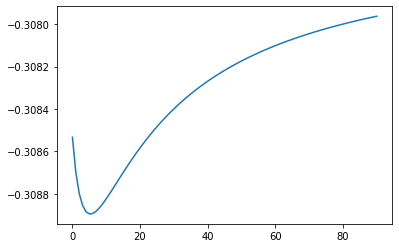

In [34]:
plt.plot(Ps)

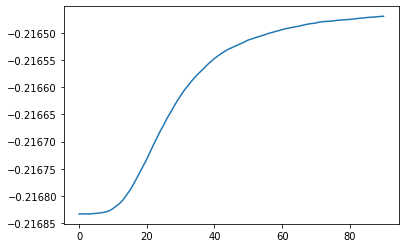

In [35]:
plt.plot(Ks)

In [36]:
temp = min(Ps)
opt_index = [i for i, j in enumerate(Ps) if j == temp]
opt_index

[5]

In [37]:
np.arange(1,10.1,0.1)[opt_index]

array([1.5])

In [38]:
Ps[opt_index[0]]

-0.3088945388262984

## With q=1.5 and all language pairs

In [39]:
for i, data in enumerate(data_list):

    wmdistances = []

    for row in tqdm(range(data.shape[0])):

        s1 = data.iloc[row,1]
        s2 = data.iloc[row,2]

        s1 = s1.lower()
        s1 = re.sub("[^a-z]", ' ', s1)
        s1 = s1.split()

        s2 = s2.lower()
        s2 = re.sub("[^a-z]", ' ', s2)
        s2 = s2.split()

        wmdistance = my_model.wmdistance(s1, s2)
        wmdistances.append(wmdistance)
        
    wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
    
    max_dist = max(wmdistances2)

    wmdistances2 = [(max_dist/1.5) if dist == -1 else dist for dist in wmdistances2]
    
    print(names_list[i])

    print('Pearson:', pearsonr(data['avg-score'], wmdistances2)[0])

    print('Kendall:', kendalltau(data['avg-score'], wmdistances2)[0])

  0%|          | 0/11585 [00:00<?, ?it/s]

cs_en
Pearson: -0.42960280668318424
Kendall: -0.2943086361107622


  0%|          | 0/21704 [00:00<?, ?it/s]

de_en
Pearson: -0.3088945388262984
Kendall: -0.21683194616228435


  0%|          | 0/6748 [00:00<?, ?it/s]

en_fi
Pearson: -0.327685921486173
Kendall: -0.22875147029027298


  0%|          | 0/10221 [00:00<?, ?it/s]

en_zh
Pearson: -0.0048874835144000995
Kendall: 0.005673120935387304


  0%|          | 0/17980 [00:00<?, ?it/s]

ru_en
Pearson: -0.30654752716016337
Kendall: -0.2136593066443208


  0%|          | 0/26419 [00:00<?, ?it/s]

zh_en
Pearson: -0.2972245166797449
Kendall: -0.19566544617853907


cs_en
Pearson: -0.4302867109402357
Kendall: -0.2946087295081448

de_en
Pearson: -0.3082085182870933
Kendall: -0.21652481793587566

en_fi
Pearson: -0.3585093522404916
Kendall: -0.2424647181157597

en_zh
Pearson: -0.05633962440065445
Kendall: -0.04644650615293067

ru_en
Pearson: -0.30558847639136544
Kendall: -0.21335539304562018

zh_en
Pearson: -0.2973579205432469
Kendall: -0.19579630984661323

## <span style="color:red">It can be seen that there is no significant correlation for Chinese (en_zh).</span>

# Solving this: Use the embeddings created with the help of Ricardo's LaSBE notebook to see if this works better with the Chinese language

## Preprocess the embedding vectors data

In [8]:
# Import embedding vector representations for our vocabulary
vectors_cs_en = pd.read_csv('/Users/philippmetzger/OneDrive/PHILIPP/NOVA IMS/2nd Semester/06 Text Mining 4 ECTS/00 Project/LaBSE/cs_en.csv')
vectors_de_en = pd.read_csv('/Users/philippmetzger/OneDrive/PHILIPP/NOVA IMS/2nd Semester/06 Text Mining 4 ECTS/00 Project/LaBSE/de_en.csv')
vectors_en_fi = pd.read_csv('/Users/philippmetzger/OneDrive/PHILIPP/NOVA IMS/2nd Semester/06 Text Mining 4 ECTS/00 Project/LaBSE/en_fi.csv')
vectors_en_zh = pd.read_csv('/Users/philippmetzger/OneDrive/PHILIPP/NOVA IMS/2nd Semester/06 Text Mining 4 ECTS/00 Project/LaBSE/en_zh.csv')
vectors_ru_en = pd.read_csv('/Users/philippmetzger/OneDrive/PHILIPP/NOVA IMS/2nd Semester/06 Text Mining 4 ECTS/00 Project/LaBSE/ru_en.csv')
vectors_zh_en = pd.read_csv('/Users/philippmetzger/OneDrive/PHILIPP/NOVA IMS/2nd Semester/06 Text Mining 4 ECTS/00 Project/LaBSE/zh_en.csv')

In [9]:
# Create a list of our vectors dataframes
vectors_dfs = [vectors_cs_en, vectors_de_en, vectors_en_fi, vectors_en_zh, vectors_ru_en, vectors_zh_en]

In [10]:
# Create a dictionary containing all our vectors. We need this format for Word Mover's distance
# This process will remove all duplicate vectors

my_dict = {}

for vectors_df in vectors_dfs:
    for i in range(vectors_df.shape[0]):
        key = vectors_df.iloc[i,0]
        values = vectors_df.iloc[i,1:].to_numpy(dtype='float32')
        my_dict[key] = values

In [11]:
# Tell Word Mover's distance which embeddings to use
my_model = model.WordEmbedding(model=my_dict)

## Define functions

In [12]:
def tokenise_ref_and_trans(data):
    """Function for tokenizing the reference and translation columns one dataset of choice."""
    
    ref_trans_tokenized = []
    
    for column in [1,2]:

        tokenized = []

        for i in tqdm(range(data.shape[0])):

            # Remove most punctuation, add space in front of full stops, question marks, and exclamation marks
            string = data.iloc[i,column].lower()
            string = string.replace('.', ' .')
            string = string.replace('?', ' ?')
            string = string.replace('!', ' !')
            string = string.replace('(', '')
            string = string.replace(')', '')
            string = string.replace('"', '')
            string = string.replace("'", '')
            string = string.replace('-', ' ')
            string = string.replace(',', ' ')
            string = string.replace(':', '')
            string = string.replace('„', '')
            string = string.replace('”', '')
            string = string.replace('：', '')
            string = string.replace('“', '')
            string = string.replace('，', '')
            string = string.replace('。', '')
            string = string.replace('.', '')

            # Remove all numbers
            string = re.sub(r'[0-9]', '', string)
            
            # If string contains chinese, tokenise it using jieba
            if re.search(u'[\u4e00-\u9fff]', string):
                split_entry = [word for word in jieba.cut(string)]
                
            # Else, just split it normally
            else:
                split_entry = string.split()
                
            # Add it to our sentence list
            tokenized.append(split_entry)

        # Add sentence list to our list of sentence lists
        ref_trans_tokenized.append(tokenized)
        
    return ref_trans_tokenized

In [13]:
def apply_wm_distance(tokenized_data):
    """A function that takes a tokenized dataset of references and translations and computes each 
    pair's Word Mover's distance and returns a vector with all the computed distances."""

    wmdistances = []
    cant_compute_ids = []

    # Iterate over all pairs
    for i in tqdm(range(len(tokenized_data[0]))):

            # Get the two sentence lists that we want to compare
            s1 = tokenized_data[0][i]
            s2 = tokenized_data[1][i]

            # Compute their Word Mover's distance from each other and append it to our list
            wmdistance = my_model.wmdistance(s1, s2)
            wmdistances.append(wmdistance)

            # If MV's distance can't compute it, log the respective ID here
            if wmdistance == np.inf:
                cant_compute_ids.append(i)
                
    print("Indices of WM's distances that could not be computed: ", cant_compute_ids)
                
    return wmdistances

In [14]:
def compute_pearson_and_kendall(wmdistances, original_dataset, factor):
    """Computes Pearson correlation coefficient and Kendall's τ coefficient between WM's distances 
    and the z-score column, assigning the value to the inf values that is defined by the passed factor"""
    
    # Replace inf values with -1 for further processing (so we can get the maximum of the WM's distances)
    wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]

    # Get the maximum of the WM's distances
    max_dist = max(wmdistances2)

    # Devide the maximum by factor and assign the resulting value to all inf values
    wmdistances2 = [(max_dist*factor) if dist == -1 else dist for dist in wmdistances2]

    # Compute
    pearson = pearsonr(original_dataset['z-score'], wmdistances2)[0]
    kendall = kendalltau(original_dataset['z-score'], wmdistances2)[0]
    
    return pearson, kendall

In [15]:
def optimise_factor(wmdistances, original_dataset, range_):
    
    Ps = []
    Ks = []
    
    for factor in range_:
        p, k = compute_pearson_and_kendall(wmdistances, original_dataset, factor)
        Ps.append(p)
        Ks.append(k)

    min_p = min(Ps)
    min_k = min(Ks)
    
    opt_index_p = [i for i, j in enumerate(Ps) if j == min_p]
    opt_index_k = [i for i, j in enumerate(Ks) if j == min_k]

    opt_factor_p = range_[opt_index_p][0]
    opt_factor_k = range_[opt_index_k][0]

    return Ps, Ks, opt_factor_p, opt_factor_k

In [16]:
def plot_opt(optim_range, values, *args):
    
    # Create figure and plot
    plt.figure
    plt.plot(optim_range, values)
    
    # Add axis titles
    plt.xlabel('factor')
    
    if len(args)>0:
        if args[0]=='pearson':
            plt.ylabel('Pearson correlation coefficient')
    else:
        plt.ylabel("Kendall's τ coefficient")
    
    plt.show()

In [17]:
# Make a train/development split; allocate 20% of our data to the training set

train = pd.DataFrame()
dev = pd.DataFrame()

for data in data_list:
    
    train_, dev_ = train_test_split(data, test_size=0.2, random_state=0, shuffle=True)
    
    train = pd.concat([train, train_])
    dev = pd.concat([dev, dev_])

In [18]:
# Compute Word Mover's distances for our training set

wmdistances = apply_wm_distance(tokenise_ref_and_trans(train))

  0%|          | 0/75724 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/c3/ddgk3fbs6w1gm4pg4tfj0d0r0000gn/T/jieba.cache
Loading model cost 0.720 seconds.
Prefix dict has been built successfully.


  0%|          | 0/75724 [00:00<?, ?it/s]

  0%|          | 0/75724 [00:00<?, ?it/s]

Indices of WM's distances that could not be computed:  [5454, 13066, 15450, 22413, 25244, 26501, 32153, 44736, 52039, 52049, 73932]


In [19]:
# Optimise for the factor that defines what value is assigned to the ones where the MV distance could not be computed

# Define a domain for the factor
optim_range = np.arange(-2,2,0.01)

# Run optimisation
Ps, Ks, opt_factor_p, opt_factor_k = optimise_factor(wmdistances, train, optim_range)

# Print optimal values in regards of Pearson correlation coefficient and Kendall's τ coefficient respectively
print('Optimal factor in respect to Pearson:', opt_factor_p)
print('Optimal factor in respect to Kendall:', opt_factor_k)

Optimal factor in respect to Pearson: 0.490000000000002
Optimal factor in respect to Kendall: 0.3400000000000021


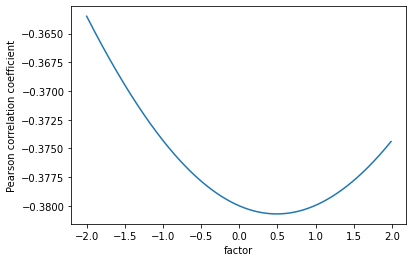

In [20]:
# Plot Pearson correlation coefficient depending on the factor
plot_opt(optim_range, Ps, 'pearson')

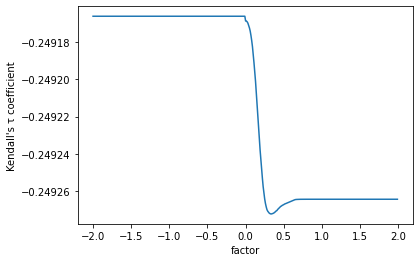

In [21]:
# Plot Kendall's τ coefficient dependign on the factor
plot_opt(optim_range, Ks)

In [22]:
# Choose an adequate value in regards to both results above:
factor = (opt_factor_p + opt_factor_k) / 2
print('factor = ', factor)

factor =  0.41500000000000203


In [24]:
pearson_train, kendall_train = compute_pearson_and_kendall(wmdistances, train, factor)
print('Pearson correlation coefficient for training set:', pearson_train)
print("Kendall's τ coefficient for training set:", kendall_train)

Pearson correlation coefficient for training set: -0.38067987332251996
Kendall's τ coefficient for training set: -0.24926995626409074


## Run on the development set

In [25]:
# Compute Word Mover's distances for our development set
wmdistances_dev = apply_wm_distance(tokenise_ref_and_trans(dev))

  0%|          | 0/18933 [00:00<?, ?it/s]

  0%|          | 0/18933 [00:00<?, ?it/s]

  0%|          | 0/18933 [00:00<?, ?it/s]

Indices of WM's distances that could not be computed:  [2514, 5864]


In [26]:
pearson_dev, kendall_dev = compute_pearson_and_kendall(wmdistances_dev, dev, factor)
print('Pearson correlation coefficient for development set:', pearson_dev)
print("Kendall's τ coefficient for development set:", kendall_dev)

Pearson correlation coefficient for development set: -0.38876128705095575
Kendall's τ coefficient for development set: -0.2550470420652122


## Run this setup on the individual language pair data sets to verify that everything is working as it should

In [27]:
results = {}

for i, data in enumerate(data_list):
    
    # Compute WM's distances
    wmdistances = apply_wm_distance(tokenise_ref_and_trans(data))
    
    # Compute Pearson correlation coefficient and Kendall's τ coefficient
    pearson_this, kendall_this = compute_pearson_and_kendall(wmdistances, data, factor)
    
    # Add these values to our dict
    results[names_list[i]] = [pearson_this, kendall_this]

  0%|          | 0/11585 [00:00<?, ?it/s]

  0%|          | 0/11585 [00:00<?, ?it/s]

  0%|          | 0/11585 [00:00<?, ?it/s]

Indices of WM's distances that could not be computed:  [11022]


  0%|          | 0/21704 [00:00<?, ?it/s]

  0%|          | 0/21704 [00:00<?, ?it/s]

  0%|          | 0/21704 [00:00<?, ?it/s]

Indices of WM's distances that could not be computed:  [1492, 3302, 6298, 8159, 9937, 11757, 13866]


  0%|          | 0/6748 [00:00<?, ?it/s]

  0%|          | 0/6748 [00:00<?, ?it/s]

  0%|          | 0/6748 [00:00<?, ?it/s]

Indices of WM's distances that could not be computed:  []


  0%|          | 0/10221 [00:00<?, ?it/s]

  0%|          | 0/10221 [00:00<?, ?it/s]

  0%|          | 0/10221 [00:00<?, ?it/s]

Indices of WM's distances that could not be computed:  [9575]


  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

Indices of WM's distances that could not be computed:  [6235, 6831, 7881]


  0%|          | 0/26419 [00:00<?, ?it/s]

  0%|          | 0/26419 [00:00<?, ?it/s]

  0%|          | 0/26419 [00:00<?, ?it/s]

Indices of WM's distances that could not be computed:  [15223]


In [28]:
pd.DataFrame(results, index=['Pearson correlation coefficient', "Kendall's τ coefficient"])

,cs_en,de_en,en_fi,en_zh,ru_en,zh_en
Pearson correlation coefficient,-0.458343,-0.338923,-0.611525,-0.438748,-0.356313,-0.346380
Kendall's τ coefficient,-0.304323,-0.229509,-0.397209,-0.289216,-0.241806,-0.227146
